# Modeling Tutorial: Quantum Functions and Entry Point

This tutorial walks through quantum functions in Qmod and the special quantum entry point `main`. You will build small examples and inspect how function signatures control the behavior of the synthesized quantum program.

It assumes that:

- The Classiq Python SDK is installed and configured.
- You are comfortable running a simple Qmod model through `synthesize` and `ExecutionSession`.
- You have basic familiarity with quantum types such as `QBit`, `QArray`, and `QNum`.

## Setup

Through this tutorial, you should import Classiq before using it:

In [1]:
from classiq import *

## 1. Concepts: quantum functions, parameters, and entry point

### Quantum functions

A quantum function is a regular Python function decorated with `@qfunc` whose body describes quantum logic: it receives quantum and classical objects as arguments, executes quantum operations, quantum control flow, and also classical control such as `repeat` and `if`.

Formally:

- The **signature** of a quantum function consists of its name and parameter list.
- The **body** is a sequence of Qmod statements that implement the intended behavior (calls to quantum operations, other quantum functions, and classical control).

### Parameter kinds

You can pass three kinds of parameters to a quantum function:

1. **Quantum parameters**  
   Variables of quantum types, such as `QBit`, `QArray[QBit]`, `QNum`, or `QStruct`.  

2. **Classical parameters**  
   Variables of classical types, such as `CInt`, `CReal`, or fixed-size `CArray`. They are often used for loop counts, indices, or rotation angles.   

3. **Function parameters**  
   Other quantum functions or operators passed as arguments, declared using types such as `QCallable[...]` or `QPerm[...]`.   

Quantum parameters can additionally carry direction modifiers that specify whether they are read-only, write-only, or both. These will be discussed in Section 2.

### Helper functions vs. the entry point

Most quantum functions are **helpers**: they encapsulate part of the algorithm and are called from other quantum functions as subroutines. 

Above there is an example of a helper function that prepares the entangled state $\vert \Psi \rangle = \cos(\alpha) \vert 00\dots 0\rangle + \sin(\alpha)\vert 11\dots 1 \rangle$:

In [2]:
from classiq import *


@qfunc
def my_entangled_state(x: QArray[QBit], alpha: CReal):
    RY(alpha, x[0])
    repeat(x.len - 1, lambda i: CX(x[i], x[i + 1]))

One function is special: the `main` function.

- Both compilation and execution start from a user-defined quantum function called `main`; it is the quantum program entry point.   
- `main` defines the interface between quantum logic and the host classical program:
  - which quantum variables are measured as outputs, and
  - which classical parameters must be supplied at execution time.   

This is an example of `main` function that calls `my_entangled_state` to prepare a 10-qubits entangled state:

In [3]:
from classiq.qmod.symbolic import pi


@qfunc
def main(x: Output[QArray[QBit, 10]]):
    allocate(x)
    my_entangled_state(x, pi / 2)

During this tutorial we will progressively refine `main` while introducing quantum parameters, direction modifiers, and execution parameters.

### Key points

- `@qfunc` marks `my_entangled_state` as a quantum function.
- `c: CReal` is a classical, real parameter; `x: QArray` is a quantum parameter. Type hints (`CReal`, `QArray`) are used by the synthesis engine to build the function signature.   
- Inside the body we combine quantum operations (`RY`, `CX`) with classical control (`repeat`) and classical parameters (`alpha`).   

Here `alpha` controls the rotation angles.

### Exercise 1 – Inspect the effect of `alpha`

Execute the quantum program for different values of `alpha` in the next cell (for example $\alpha \in \{n \,\pi / 10\}_{n = 1, 2, \dots}$). Tip: you can execute a single quantum program with different values of $\alpha$. Check out the [Execution Tutorial](https://docs.classiq.io/latest/getting-started/classiq_tutorial/execution_tutorial/).

What happens when $\alpha = n \pi$, for integer $n$?


In [4]:
alpha = pi / 7


@qfunc
def main(x: Output[QArray[QBit, 10]]):
    allocate(x)
    my_entangled_state(x, alpha)  # Try different values for alpha


qprog = synthesize(main)
show(qprog)

with ExecutionSession(qprog, ExecutionPreferences(num_shots=1000)) as es:
    result = es.sample()

display(result.dataframe)

Quantum program link: https://platform.classiq.io/circuit/36Zf3vytZnb7RvMQvQG8EUY5k1a


,x,count,probability,bitstring
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",948,0.948,0000000000
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",52,0.052,1111111111


### What to inspect

In the sampled results:

- For small `alpha` values, check that the outputs are mainly concentrated in $\vert 00\dots 0\rangle$.
- As `alpha` gets closer to $\pi/2$, the outputs gets closer to an equal distribution of $\vert 00\dots 0\rangle$ and $\vert 11\dots 1\rangle$ states.

The exact numerical values are not important here; the goal is to see how a quantum function combines quantum and classical parameters.


## 2. Quantum parameter direction modifiers

Quantum parameters can be annotated with direction modifiers that describe which function is responsible for initializing the quantum variable and how it flows through the quantum program. These are represented by wrappers such as `Input[...]` and `Output[...]` around a quantum type.   

- **`Input[T]`**  
  The function expects the quantum variable to already be initialized when it is called. It may read and transform the state, but it does not allocate new qubits for this variable.   

- **`Output[T]`**  
  The function must initialize the variable, typically by calling `allocate`, assigning to it, or binding it to another quantum object. At function entry, the variable is uninitialized.     

Direction modifiers apply only to **quantum** parameters. Classical and function parameters are always passed as classical values and cannot be marked as `Input` or `Output`.

Variables without an explicit direction modifier are set to `Input` by default.

One way to visualize this is to think of variables as arrows crossing a function box:

- Initialized input variables (`Input`) enter from the left.
- Newly initialized output variables (`Output`) leave on the right.

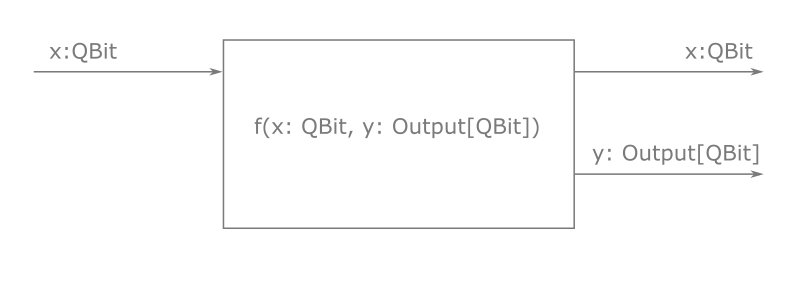

The quantum function accepts **only** `Output` types.


### Key points

- In `f`, `x` is declared without a modifier, so it behaves like an input parameter: the caller must pass an initialized quantum variable, and `f` may use it but does not allocate it.   
- `y: Output[QBit]` is an output-only parameter. At function entry it is uninitialized; `f` must initialize it before using it as a target of operations.   
- Local quantum variables declared inside a quantum function behave like output-only parameters at first: they are uninitialized until they are allocated, assigned, or bound.

### Exercise 2 – Input vs Output

1. Write a function `copy_qubit(src: QBit, dst: Output[QBit])` that uses the [CX gate](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/standard_gates/#classiq.qmod.builtins.functions.standard_gates.CX) to copy the logical value of `src` into `dst`.  
2. Write a `main` function that:
   - Allocates the source qubit and prepares it in $|1\rangle$ by applying the [Pauli-X gate](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/standard_gates/#classiq.qmod.builtins.functions.standard_gates.X).
   - Calls `copy_qubit`.
   - Declares both `src` and `dst` as quantum outputs of `main`.  
3. Synthesize and sample the model, and verify that `src` and `dst` always have the same measured value.

In [5]:
@qfunc
def copy_qubit(src: QBit, dst: Output[QBit]):
    # enter your code here, remove pass
    # allocate()
    # CX()
    pass


@qfunc
def main(src: Output[QBit], dst: Output[QBit]):
    # Complete the function's body. Which variable should be allocated here, and which should be allocated at copy_qubit? Remove pass
    # allocate()
    # X()
    # copy_qubit()
    pass

## 3. The main function as quantum entry point

The function named `main` plays a special role in Qmod:

- It is the **entry point** of the quantum program: compilation and execution start from this function.   
- It specifies:
  - which quantum outputs are measured, and  
  - which classical execution parameters must be provided when executing a quantum program.   

### Quantum outputs in `main`

`main` may declare quantum parameters only as outputs, using `Output[...]`. These variables are measured at the end of execution when using operations such as `sample`, and their values are interpreted according to their quantum types.   

You cannot declare quantum inputs in `main`; the classical execution environment cannot pass an existing quantum state into the entry point. All quantum state must be created inside the model.


## 4. Classical execution parameters in `main`

Besides quantum outputs, `main` can declare classical parameters of scalar types (`CInt`, `CReal`) and fixed-size arrays thereof ( `CArray`). These are called execution parameters. They:   

- are assigned by the classical execution via arguments to `sample` or `estimate`, and  
- remain symbolic inside the compiled quantum program, so you can reuse the same compiled circuit for different parameter values without re-synthesizing.

Execution parameters can only appear in restricted contexts. Some examples are:   

- as rotation angles in gate-level functions (for example `RX(angle, q)`), and  
- as the exponent in the `power` operation.

They cannot be used in:

- classical control flow (`repeat`, `if`), or  
- array indices or slice expressions.

This restriction ensures that all control-flow decisions are resolved at compile or link time, and only continuous parameters such as rotation angles remain symbolic.

This is an example of `main` that depends on a real (`CReal`) parameter:

In [6]:
@qfunc
def main(angle: CReal, res: Output[QBit]):
    allocate(res)
    RX(angle, res)

In [7]:
import numpy as np

qprog = synthesize(main)
show(qprog)

theta_list = [np.pi / 5, np.pi / 4, np.pi / 3, np.pi / 2, 3 * np.pi / 5, 3 * np.pi / 4]

angles = [{"angle": angle_value} for angle_value in theta_list]
# Try several rotation angles without re-synthesizing the model
with ExecutionSession(qprog, ExecutionPreferences(num_shots=1000)) as es:
    result = es.batch_sample(angles)

Quantum program link: https://platform.classiq.io/circuit/36Zf4M4KyoydUHQz6jKAswCeqEP


As explained in the [Execution tutorial](https://docs.classiq.io/latest/getting-started/classiq_tutorial/execution_tutorial_part2/#expectation-values-and-parameterized-quantum-programs), it is possible to plot the sampling populations as a function of the parameter `angle`:

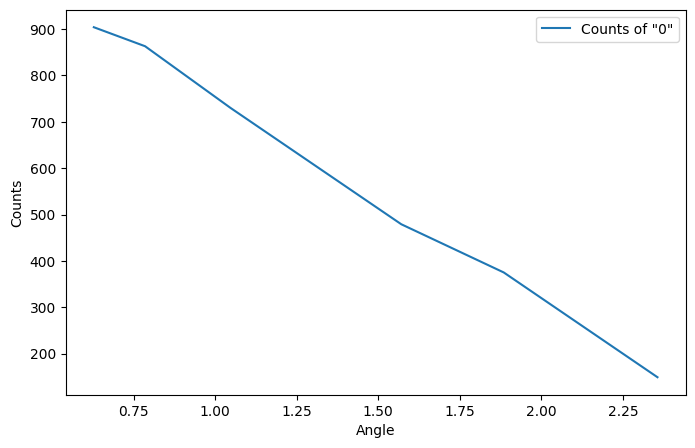

In [8]:
import matplotlib.pyplot as plt

pops_0 = [pops.counts.get("0", 0) for pops in result]

plt.figure(figsize=(8, 5))
plt.plot(theta_list, pops_0, label='Counts of "0"')
plt.xlabel("Angle")
plt.ylabel("Counts")
plt.legend()
plt.show()

### Key points

- `main` has one classical execution parameter `angle: CReal` and one quantum output `res: Output[QBit]`.  
- `angle` is used only as the rotation parameter of `RX`, which is an allowed context for execution parameters.   
- The quantum program `qprog` is synthesized once; successive calls to `sample` provide different values for `angle` via a dictionary of parameter assignments.   

### Exercise 3 – Add a second parameter

Extend `main` to:

1. Add an integer parameter `k: CInt`.  
2. Use `k` only to scale the angle in `RX`, for example by calling `RX(k * angle, res)`.  
3. Modify the sampling loop so that both `angle` and `k` vary between iterations.  
4. Confirm that:
   - The code still runs (because `k` appears only in a rotation expression).
   - The measured probabilities depend on both parameters.

In [9]:
# Modify the main function to accept k as a parameter
@qfunc
def main(angle: CReal, res: Output[QBit]):
    allocate(res)
    RX(angle, res)


import numpy as np

qprog = synthesize(main)

theta_list = [np.pi / 5, np.pi / 4, np.pi / 3, np.pi / 2, 3 * np.pi / 5, 3 * np.pi / 4]
k_list = [0, 1, 2, 3, 4]

parameters = [
    {"angle": angle_value, "k": k} for angle_value in theta_list for k in k_list
]

# Try different parameters without re-synthesizing the model
with ExecutionSession(qprog, ExecutionPreferences(num_shots=1000)) as es:
    result = es.batch_sample(parameters)

## 5. Passing quantum functions as parameters (operators)

Quantum functions can also take other quantum functions as parameters. This is useful for expressing reusable algorithmic patterns such as phase estimation, amplitude amplification, and custom data encodings. Such higher-order quantum functions are referred to as **operators**.   

In [10]:
@qfunc
def apply_twice(op: QCallable[CReal, QBit], theta: CReal, q: QBit):
    op(theta, q)
    op(theta, q)


@qfunc
def main(res: Output[QBit]):
    allocate(res)
    apply_twice(lambda angle, target: RX(angle, target), pi / 4, res)


qprog = synthesize(main)

### Notes

- `op: QCallable[CReal, QBit]` declares a parameter whose type is “a quantum function that takes a `CReal` and a `QBit`”.
- In `main` we pass a Python `lambda` that matches this signature and calls `RX`. [Click here](https://docs.classiq.io/latest/qmod-reference/language-reference/operators/#lambda-functions) to learn more about lambda functions usage in Qmod.
- When synthesizing the model, the compiler inlines the lambda body and constructs an explicit sequence of two `RX` gates.

### Exercise 4 – Swap `RX` for `RY`

Modify `main` and `apply_twice` to call `apply_twice` twice:

1. Both `main` and `appy_twice` should accept a `q: QArray[QBit]` now.
1. Once with an `RXX`-based lambda.  
2. Once with an `RY`-based lambda in both qubits.

Synthesize the model and verify that you see the rotation gates in the resulting quantum program.

## 6. Learning checklist

After completing this tutorial, you should be comfortable with:

- Explaining what a quantum function is in Qmod and how to properly use the `@qfunc` decorator.   
- Declaring functions with quantum, classical, and function parameters, and understanding how type hints define the function signature.   
- Using direction modifiers (especially `Output`) for quantum parameters and reasoning about when to initialize certain quantum variables.   
- Declaring the entry-point function `main`, specifying quantum outputs, and understanding how they are measured and returned.   
- Adding classical execution parameters to `main`, using them in allowed contexts (such as rotation angles and `power` exponents), and passing values at execution time without re-synthesizing.   
- Passing quantum functions as parameters via `QCallable` and recognizing this pattern in more advanced algorithms.   

### Documentation reference

You can now safely navigate the following documentation pages for more details:

- If you want to see another examples of usage, take a look at the [Modeling Guides].  
- For a technical, complete explanation of quantum functions and quantum entry point, see the language reference pages [Quantum Functions](https://docs.classiq.io/latest/qmod-reference/language-reference/functions/) and [Quantum Entry Point](https://docs.classiq.io/latest/qmod-reference/language-reference/quantum-entry-point/).